<a href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/TeachingMaterials/2021-10-NIHLibrarySession/BigQueryMachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to BigQuery Machine Learning

This notebook demonstrates how to build a BigQuery Machine Learning (ML) model to predict breast cancer tumor status (i.e., tumor vs. normal) using RNA-seq data. For a more general overview of machine learning, see this [review](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf). 

This notebook steps through the following process, which is also illustrated in the figure below:

1. Retrieve the data from the ISB-CGC BigQuery table and split it into training and testing data. 
2. Optimize model parameters, including feature size, normalization method, classifier type, and classifier parameters. In this tutorial, we will make assumptions about the optimal parameters. 
3. Normalize the data. 
4. Select features, i.e., differentially expressed genes to be used in the prediction model.
5. Train the prediction model.
6. Evaluate the prediction model's performance.
7. Use the model to predict the labels of future samples.

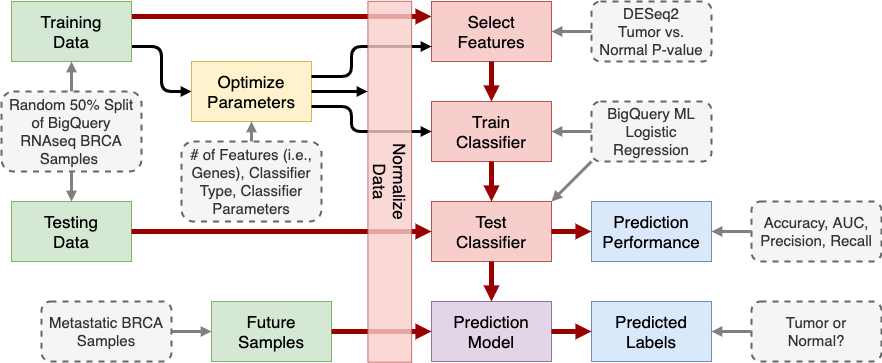



This notebook queries and creates data tables and models in BigQuery and may incur some costs. Though the costs for this notebook's operations are minimal, we urge you to be cautious when running BigQuery commands. Please see [Google's BigQuery Pricing](https://cloud.google.com/bigquery/pricing) page for more information. 

## Contact Us

Please contact us to learn more about BigQuery, to discuss cost considerations when working with BigQuery projects, or to discuss any projects you feel may benefit from the ISB-CGC Platform. 

- Email us: [feedback@isb-cgc.org](mailto:feedback@isb-cgc.org)
- Check out our website: [https://isb-cgc.org](https://isb-cgc.org)
- Visit our [office hours](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/office_hours.html)

## Glossary of Terms

Refer to the following tables of terms as you work through the notebook.

### BigQuery Projects and Tables

This notebook will read and/or create the following BigQuery tables or ML models. 

| Term | Description |
| :- | :- |
| isb-cgc-bq | Name of the BigQuery project containing public ISB-CGC data |
| TCGA_versioned | Name of the BigQuery dataset containing versioned TCGA data |
| RNAseq_hg38_gdc_r28 | Name of the BigQuery table containing TCGA gene expression data |
| tcga_brca_ml\_table\_* | Name of the temporary BigQuery table created for BigQuery ML |
| tcga_brca_ml\_model\_* | Name of the BigQuery ML model created by this notebook |


### BigQuery Table Fields of Interest

The following are RNAseq_hg38_gdc_r28 table fields used in this notebook. See the [ISB-CGC BigQuery Table Search](https://isb-cgc.appspot.com/bq_meta_search/) for more details. 

| Term | Description |
| :- | :- |
| case_barcode | Original case barcode |
| gene_name | Gene name e.g., TTN, DDR1, etc. |
| HTSeq__Counts | Number of mapped reads to each gene as calculated by the Python package HTSeq. (See [documentation](https://docs.gdc.cancer.gov/Encyclopedia/pages/HTSeq-Counts/) for more information)  |
| HTSeq__FPKM_UQ | FPKM is implemented at the GDC on gene-level read counts that are produced by HTSeq1 and generated using custom scripts. (See [documentation](https://docs.gdc.cancer.gov/Encyclopedia/pages/HTSeq-FPKM/) for more information) |
| sample_type_name | The longer name of the sample type; e.g. Primary Tumor, Solid Normal Tissue, Metastatic, etc. |
| gene_type | The type of genetic element to which the reads mapped; e.g. protein_coding, ribozyme, etc. |
| project_short_name | Project name abbreviation; the program name appended with a project name abbreviation; e.g., TCGA-BRCA, etc. |

### Important BigQuery Functions

More information about BigQuery SQL syntax can be found [here](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax). 

| Term | Description |
| :- | :- |
| CREATE OR REPLACE MODEL | Create a BigQuery ML model |
| ML.EVALUATE | Evaluate the performance of a BigQuery ML model |
| ML.PREDICT | Predict the labels and class probabilities of a BigQuery ML Model |
| FARM_FINGERPRINT | Generates a "random" integer from a string, useful for data splitting |
| UNION ALL | Combine the results of multiple queries |
| PIVOT | Convert table rows to columns |

# Initialize Notebook Environment

Before running the analysis, install and load dependencies, authenticate to BigQuery, and customize notebook parameters. 

## Install and Load Dependencies
Load all R package dependencies, installing if necessary. 

In [ ]:
# BigQuery library
if (!require(bigrquery)) {
  print('Installing bigrquery package')
  install.packages('bigrquery')
  if (!require(bigrquery)) {
    print('Cannot install bigrquery package')
  }
}

# Tidyr package
if (!require('tidyr')) {
  print('Installing tidyr package')
  install.packages('tidyr')
  if (!require('tidyr')) {
    print('Cannot install tidyr')
  }
}

# Scales package to support visualization
if (!require('scales')) {
  print('Installing scales package')
  install.packages('scales')
  if (!require('scales')) {
    print('Cannot install scales')
  }
}

# Resample package for basic statistical functions
if (!require('resample')) {
  print('Installing resample package')
  install.packages('resample')
  if (!require('resample')) {
    print('Cannot install resample')
  }
}

# Digest package for generating random strings
if (!require('digest')) {
  print('Installing digest package')
  install.packages('digest')
  if (!require('digest')) {
    print('Cannot install digest')
  }
}

## Authenticate to Access BigQuery

Before using BigQuery, we need to get authorization for access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html). R notebooks that use the BigRQuery library need the following work-around to authenticate. See the following link: https://gist.github.com/jobdiogenes/235620928c84e604c6e56211ccf681f0

In [ ]:
# NOTE: this cell is only required if you're using Google Colab
if (!require('R.utils')) {
    print('Installing R.utils package')
    install.packages("R.utils")
    if (!require('R.utils')) {
        print('Cannot install R.utils package')
    }
}

if (!require('httr')) {
    print('Installing httr package')
    install.pckages('httr')
    if (!require('httr')) {
        print('Cannot install httr package')
    }
}

my_check <- function() {return(TRUE)}
reassignInPackage("is_interactive", pkgName = "httr", my_check) 
options(rlang_interactive=TRUE)

In [ ]:
# Now authenticate to BQ. Be sure to select the BigQuery scope!
bq_auth(use_oob = TRUE, cache = TRUE)

## Set Parameters
Set or update notebook parameters in this section.

In [4]:
# Generate a random string so that your tables and models are unique
my_name <- "My Name" ### important, change this to your name
current_date <- as.character(as.numeric(Sys.time()))

# create a random string
hash <- substr(
  digest(paste(my_name, current_date, sep = ''), algo = "sha256"), 1, 8
)

print(sprintf('Your random hash: %s', hash))

[1] "Your random hash: 4ebe20a6"


In [5]:
# set the google project that will be billed for this notebook's computations
google_project <- 'google-project'  ## CHANGE ME

# Set the number of feature to use for the ML model. This corresponds to the
# number of genes to use in the dataset used to train/test the ML model.
num_ml_features <- 30

# BQ project for storing tmp table and ML model
bq_project <- 'bq_project' ## CHANGE ME

# BQ dataset for storing tmp table and ML model
bq_dataset <- 'bq_dataset' ## CHANGE ME

# BQ tmp table name for training and testing data
bq_tmp_table <- paste('tcga_brca_ml_table_', hash, sep = '') 

# Name of BQ ML model
bq_ml_model <- paste('tcga_brca_ml_model_', hash, sep = '')

# Prepare Gene Expression Data for Prediction Modeling

In the first step, we construct a query to extract data from a BigQuery table, then prepare it for feature selection and prediction modeling by splitting it into training and testing sets. More information about data splitting can be found [here](https://developers.google.com/machine-learning/crash-course/training-and-test-sets/splitting-data). 

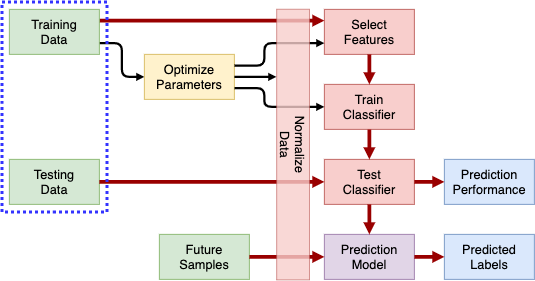


## Query Gene Expression Data

The first component of the query extracts expression values of all TCGA-BRCA protein-coding genes:

In [6]:
rna_brca_query <- sprintf("
  -- This table contains RNAseq expression of protein-coding genes for  
  -- TCGA BRCA normal and cancer samples. 
  SELECT 
    case_barcode,
    gene_name,
    HTSeq__Counts,
    HTSeq__FPKM_UQ,
    sample_type_name

  FROM `isb-cgc-bq.TCGA_versioned.RNAseq_hg38_gdc_r28` AS tcga_rna

  WHERE
    gene_type = 'protein_coding'
    AND project_short_name = 'TCGA-BRCA'
")

## Filter Samples Using Metadata

Using the table created by the previous query, we filter the cases to include only cases that have BOTH tumor and normal samples and no metastatic samples. 

In [7]:
cases_query <- sprintf("
  -- This table filters for cases that include both normal and tumor samples
  SELECT
    case_barcode,
    agg_sample_type_name

  FROM (
    SELECT
      case_barcode,
      -- combine all sample types for each case into a single array
      ARRAY_AGG(DISTINCT sample_type_name) AS agg_sample_type_name

    FROM rna_brca
    
    GROUP BY case_barcode
  )
  
  WHERE 
    'Solid Tissue Normal' IN UNNEST(agg_sample_type_name)
    AND 'Primary Tumor' IN UNNEST(agg_sample_type_name)
    AND 'Metastatic' NOT IN UNNEST(agg_sample_type_name)
")

## Label Samples and Split into Training & Testing Sets

Now we join the "rna_brca" and "cases" tables to produce the final query. 

In [8]:
# Construct the final query
ge_query <- sprintf("
WITH rna_brca AS (%s),

cases AS (%s)

SELECT 
  rna_brca.case_barcode,
  gene_name,
  
  -- In situations where there are multiple records for each case, take the 
  -- highest RNAseq count value as the expression for that gene
  MAX(HTSeq__Counts) AS gene_expression,
  sample_type_name,

  CASE
    -- Assign a numeric label to each case depending on sample type
    WHEN sample_type_name = 'Primary Tumor' THEN 1
    WHEN sample_type_name = 'Solid Tissue Normal' THEN 0
  END AS label,

  CASE
    -- Randomly assign each case to the training or testing dataset
    WHEN MOD(ABS(FARM_FINGERPRINT(rna_brca.case_barcode)), 10) < 5 THEN 'training'
    WHEN MOD(ABS(FARM_FINGERPRINT(rna_brca.case_barcode)), 10) >= 5 THEN 'testing'
  END AS data_partition

FROM rna_brca

INNER JOIN cases 
  ON rna_brca.case_barcode = cases.case_barcode

GROUP BY case_barcode, gene_name, sample_type_name
ORDER BY gene_name, case_barcode
", rna_brca_query, cases_query)

# Display the final query
cat(ge_query)


WITH rna_brca AS (
  -- This table contains RNAseq expression of protein-coding genes for  
  -- TCGA BRCA normal and cancer samples. 
  SELECT 
    case_barcode,
    gene_name,
    HTSeq__Counts,
    HTSeq__FPKM_UQ,
    sample_type_name

  FROM `isb-cgc-bq.TCGA_versioned.RNAseq_hg38_gdc_r28` AS tcga_rna

  WHERE
    gene_type = 'protein_coding'
    AND project_short_name = 'TCGA-BRCA'
),

cases AS (
  -- This table filters for cases that include both normal and tumor samples
  SELECT
    case_barcode,
    agg_sample_type_name

  FROM (
    SELECT
      case_barcode,
      -- combine all sample types for each case into a single array
      ARRAY_AGG(DISTINCT sample_type_name) AS agg_sample_type_name

    FROM rna_brca
    
    GROUP BY case_barcode
  )
  
  WHERE 
    'Solid Tissue Normal' IN UNNEST(agg_sample_type_name)
    AND 'Primary Tumor' IN UNNEST(agg_sample_type_name)
    AND 'Metastatic' NOT IN UNNEST(agg_sample_type_name)
)

SELECT 
  rna_brca.case_barcode,
  gene_name,
  
 

## Execute the Query to Retrieve Data

In [9]:
# Run the query
ge_table <- bq_project_query(google_project, ge_query, quiet = TRUE)

# Download the query result
ge_data <- bq_table_download(ge_table, quiet = TRUE)

# Show the dataframe
head(ge_data)

case_barcode,gene_name,gene_expression,sample_type_name,label,data_partition
<chr>,<chr>,<int>,<chr>,<int>,<chr>
TCGA-A7-A0CE,A1BG,11,Primary Tumor,1,training
TCGA-A7-A0CE,A1BG,28,Solid Tissue Normal,0,training
TCGA-A7-A0CH,A1BG,26,Solid Tissue Normal,0,testing
TCGA-A7-A0CH,A1BG,21,Primary Tumor,1,testing
TCGA-A7-A0D9,A1BG,26,Primary Tumor,1,testing
TCGA-A7-A0D9,A1BG,5,Solid Tissue Normal,0,testing


The previous query labeled the data as either "training" or "testing" using the "FARM_FINGERPRINT" function. More information about that function can be found [here](https://cloud.google.com/bigquery/docs/reference/standard-sql/hash_functions). We use those labels to pull the training data into a data frame. 

In [10]:
# Pull the training data into a data frame
ge_train_data <- ge_data[ge_data$data_partition == 'training',]

# Display preview of data frame
head(ge_train_data)

case_barcode,gene_name,gene_expression,sample_type_name,label,data_partition
<chr>,<chr>,<int>,<chr>,<int>,<chr>
TCGA-A7-A0CE,A1BG,11,Primary Tumor,1,training
TCGA-A7-A0CE,A1BG,28,Solid Tissue Normal,0,training
TCGA-A7-A0DB,A1BG,6,Solid Tissue Normal,0,training
TCGA-A7-A0DB,A1BG,47,Primary Tumor,1,training
TCGA-AC-A2FM,A1BG,48,Solid Tissue Normal,0,training
TCGA-AC-A2FM,A1BG,259,Primary Tumor,1,training


## Pivot Data Frame

Now we pivot the data frame so that each row corresponds to a gene or a sample label, and each column corresponds to a sample. This makes it easier to analyze downstream. We use the "spread()" function to do this:

In [11]:
# Create pivot table
ge_train_data_pivot = spread(
  ge_train_data,
  key = 'gene_name',
  value = 'gene_expression'
)

# Display preview of table
head(ge_train_data_pivot)

case_barcode,sample_type_name,label,data_partition,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
TCGA-A7-A0CE,Primary Tumor,1,training,11,11,30166,89,5,405,⋯,3634,4032,413,1297,1659,189,2970,13762,4390,3752
TCGA-A7-A0CE,Solid Tissue Normal,0,training,28,10,136313,114,2,2279,⋯,788,775,258,1314,2153,235,2544,22402,4525,3802
TCGA-A7-A0DB,Primary Tumor,1,training,47,33,35509,26,4,514,⋯,899,1536,405,1327,1879,196,3513,10182,3501,3236
TCGA-A7-A0DB,Solid Tissue Normal,0,training,6,0,90997,52,0,1593,⋯,445,387,251,702,1281,6,3098,9682,3871,1591
TCGA-AC-A2FM,Primary Tumor,1,training,259,4,24126,12,0,2894,⋯,1086,1823,376,2743,2153,143,1676,8745,7277,1806
TCGA-AC-A2FM,Solid Tissue Normal,0,training,48,3,61379,17,2,2053,⋯,464,238,158,715,1336,128,1185,35824,2896,2001


# Optimize Parameters and Normalize Data

In practice, parameter optimization and data normalization is required before feature selection and classifier training.

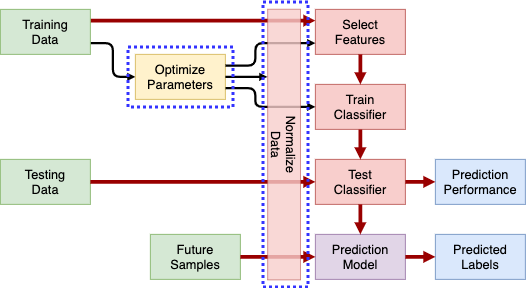

We make assumptions about optimal parameters to simplify this example. These assumptions are:

1. The number of features for the prediction model is **30**.
2. The classifier to be used for the prediction model is **Logistic Regression**.

Optimization of these parameters would require a procedure such as cross validation to estimate prediction performance for each combination of parameters. See [Phan et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4983434/) and [Tong et al.](https://www.nature.com/articles/s41598-020-74567-y) for more details.  

Data normalization is also an essential step, but can depend on the feature selection method and classifier. Moreover, normalization may need to be applied at various stages throughout the analysis process. Caution must be taken to avoid leakage of information from the testing data or from future samples when normalizing the training data. 

In this example, we use the following normalization methods:

1. We use RNA-seq raw counts (un-normalized data) when selecting features using DESeq. 
2. When training the classifier, we use log of FPKM upper quartile normalization. We use the same normalization method for testing data and future samples. This normalization method can be applied to each sample independently, so there is no danger of information leakage. See the [NCI GDC Documentation](https://docs.gdc.cancer.gov/Encyclopedia/pages/HTSeq-FPKM-UQ/) for more information. 
3. When visualizing the data use Principal Component Analysis (PCA), we mean center and scale the data to unit variance. The means and variances used for shifting and scaling data are calculated **only with the training data**, then applied to the testing and future data.

# Identify Differentially Expressed Genes

Now that we have extracted the data and split it into training and testing sets, we can identify features to be used for prediction modeling. 

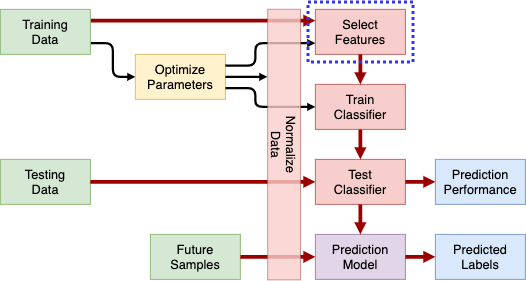

We can use DESeq to identify genes differentially expressed between tumor and normal samples. It is important that this analysis is performed **using only the the training data** in order to ensure that information from the testing data does not "leak" into the machine learning training process. Such leakage can bias estimated prediction performance of the resulting machine learning model.

In this tutorial, we assume that DESeq has been applied to the training data, resulting in the following top 30 differentially expressed genes. 

In [12]:
gene_list <- "'COL10A1', 'MMP11', 'ADAMTS5', 'CAPN11', 'FIGF', 'PAMR1', 'KLHL29', 'INHBA', 'PPAPDC1A', 'LYVE1', 'COL11A1', 'WISP1', 'MT1M', 'NRG2', 'HOXA4', 'CA4', 'MMP13', 'NEK2', 'MAMDC2', 'PPP1R14A', 'SLC24A2', 'PER1', 'SCARA5', 'COMP', 'SPRY2', 'TPX2', 'ROBO3', 'CXCL2', 'NDRG2', 'HSD17B6'"

# Train a Prediction Model using BigQuery ML

Now that differentally expressed genes have been identified to be used as features for the prediction model, we can train the Logistic Regression model using BigQuery ML.

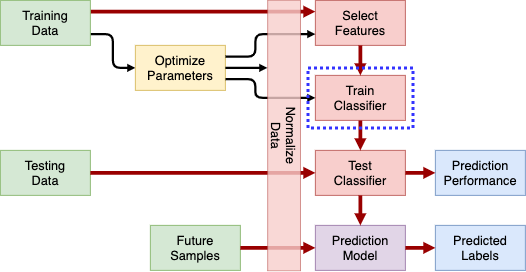

## Prepare Query to Create Subset Table for BigQuery ML

For this step, we need to re-run the previous query to pull RNA-seq gene expression data from the TCGA RNA-seq BigQuery table and join it with clinical labels. We modify this query as follows:

1. Extract the normalized FPKM gene expression data rather than raw counts.
2. Pivot the data for use with BigQuery ML.
3. Store the data in a separate table to reduce BigQuery costs. 

Recall that the query labels the samples based on whether they are normal or tumor samples. Tumor samples are labeled as "1" while normal samples are labeled as "0". This is the same procedure that we used to label the samples for differential expression analysis. 

Creation of a new BQ table with only the data of interest reduces the size of the data passed to BQ ML and can significantly reduce the cost of running BQ ML queries. This query also randomly splits the dataset into "training" and "testing" sets using the "FARM_FINGERPRINT" hash function in BigQuery. "FARM_FINGERPRINT" generates an integer from the input string. More information can be found [here](https://cloud.google.com/bigquery/docs/reference/standard-sql/hash_functions).

In [13]:
# Construct a query that extracts all RNAseq expression data for samples and 
# genes of interest, labels the samples by tumor/normal status, partitions
# the dataset into training and testing sets, and pivots the table
ge_pivot_query <- sprintf("
WITH rna_brca AS (%s),

cases AS (%s)

SELECT * FROM (
  SELECT 
    rna_brca.case_barcode,
    gene_name,
  
    -- In situations where there are multiple records for each case, take the 
    -- highest RNAseq count value as the expression for that gene
    MAX(LOG(HTSeq__FPKM_UQ+1)) AS gene_expression,
    sample_type_name,

    CASE
      -- Assign a numeric label to each case depending on sample type
      WHEN sample_type_name = 'Solid Tissue Normal' THEN 0
      WHEN sample_type_name = 'Primary Tumor' THEN 1
    END AS label,

    CASE
      -- Randomly assign each case to the training or testing dataset
      WHEN MOD(ABS(FARM_FINGERPRINT(rna_brca.case_barcode)), 10) < 5 THEN 'training'
      WHEN MOD(ABS(FARM_FINGERPRINT(rna_brca.case_barcode)), 10) >= 5 THEN 'testing'
    END AS data_partition

  FROM rna_brca

  INNER JOIN cases 
    ON rna_brca.case_barcode = cases.case_barcode

  GROUP BY case_barcode, gene_name, sample_type_name

  UNION ALL -- add 'Metastatic' samples to simulate predicting future samples

  SELECT 
    rna_brca.case_barcode,
    gene_name,
    MAX(LOG(HTSeq__FPKM_UQ+1)) AS gene_expression,
    sample_type_name,

    -- distinguish these samples from normal and tumor samples
    2 AS label, 
    'future' AS data_partition

  FROM rna_brca

  WHERE sample_type_name = 'Metastatic'

  GROUP BY case_barcode, gene_name, sample_type_name
)

PIVOT (
  MAX(gene_expression) FOR gene_name IN (%s)
)

ORDER BY case_barcode, data_partition, label
", rna_brca_query, cases_query, gene_list)

# Display the full query
cat(ge_pivot_query)


WITH rna_brca AS (
  -- This table contains RNAseq expression of protein-coding genes for  
  -- TCGA BRCA normal and cancer samples. 
  SELECT 
    case_barcode,
    gene_name,
    HTSeq__Counts,
    HTSeq__FPKM_UQ,
    sample_type_name

  FROM `isb-cgc-bq.TCGA_versioned.RNAseq_hg38_gdc_r28` AS tcga_rna

  WHERE
    gene_type = 'protein_coding'
    AND project_short_name = 'TCGA-BRCA'
),

cases AS (
  -- This table filters for cases that include both normal and tumor samples
  SELECT
    case_barcode,
    agg_sample_type_name

  FROM (
    SELECT
      case_barcode,
      -- combine all sample types for each case into a single array
      ARRAY_AGG(DISTINCT sample_type_name) AS agg_sample_type_name

    FROM rna_brca
    
    GROUP BY case_barcode
  )
  
  WHERE 
    'Solid Tissue Normal' IN UNNEST(agg_sample_type_name)
    AND 'Primary Tumor' IN UNNEST(agg_sample_type_name)
    AND 'Metastatic' NOT IN UNNEST(agg_sample_type_name)
)

SELECT * FROM (
  SELECT 
    rna_brca.case_barcod

## Create Subset Table for BigQuery ML

Run the query to create the table. This table contains only the samples and genes that we need to train the machine learning model. 

In [14]:
# Delete the tmp table if it exists
bq_tmp_table_fullname <- paste(bq_project, bq_dataset, bq_tmp_table, sep = '.')
if (bq_table_exists(bq_tmp_table_fullname)) {
  bq_table_delete(bq_tmp_table_fullname)
}

# Run the query to create the temporary or subset table
ge_pivot_table <- bq_project_query(
  google_project,
  ge_pivot_query,
  destination_table = bq_tmp_table_fullname,
  quiet = TRUE
)

## Preview Subset Table

Let's take a look at this subset table. The data has been pivoted such that each of the genes is available as a column that can be "SELECTED" in a query. In addition, the "label" and "data_partition" columns simplify data handling for classifier training and evaluation.  

In [15]:
tmp_table_query <- sprintf("
  SELECT
    * --usually not recommended to use *, but in this case, we want to see all genes
  FROM `%s`
", bq_tmp_table_fullname)

# Run the query
tmp_table <- bq_project_query(google_project, tmp_table_query, quiet = TRUE)

# Download the query result
tmp_data <- bq_table_download(tmp_table, quiet = TRUE)

# Show the dataframe
head(tmp_data)

case_barcode,sample_type_name,label,data_partition,COL10A1,MMP11,ADAMTS5,CAPN11,FIGF,PAMR1,⋯,SLC24A2,PER1,SCARA5,COMP,SPRY2,TPX2,ROBO3,CXCL2,NDRG2,HSD17B6
<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCGA-A7-A0CE,Solid Tissue Normal,0,training,8.084782,10.007771,12.001531,11.652749,12.509690,13.530618,⋯,4.780028,13.68064,12.514925,10.44850,12.91842,11.03459,10.611805,13.130767,13.81798,9.144254
TCGA-A7-A0CE,Primary Tumor,1,training,11.946598,11.708615,10.262342,8.422632,9.283322,9.807365,⋯,7.357463,13.50760,7.316013,13.21607,11.95265,13.30444,8.054271,11.131740,12.56180,10.584979
TCGA-A7-A0CH,Solid Tissue Normal,0,testing,8.797859,10.581771,12.342606,10.633858,12.971092,13.076344,⋯,5.368873,13.37971,13.289296,10.26660,12.96287,10.88753,10.703300,12.257179,13.78315,8.840313
TCGA-A7-A0CH,Primary Tumor,1,testing,14.359123,13.958606,10.110411,8.428334,7.290992,9.604073,⋯,9.899814,11.31264,4.631522,13.92135,10.72367,12.05078,8.169261,9.694843,11.86710,10.889042
TCGA-A7-A0D9,Solid Tissue Normal,0,testing,8.430422,9.907031,12.693907,10.593507,12.863596,12.284105,⋯,3.918165,13.61539,14.402506,11.32945,13.28733,10.32815,10.421386,12.735412,13.65413,7.850524
TCGA-A7-A0D9,Primary Tumor,1,testing,13.501683,14.257378,9.463249,9.269666,9.714173,9.975251,⋯,9.418867,11.99268,8.776945,13.90754,11.00835,11.73164,8.448684,8.776381,11.65811,10.777710


## Train the Machine Learning Model

Now we can train a classifier using BigQuery ML with the data stored in the subset table. This model will be stored in the location specified by the "bq_ml_model" variable, and can be reused to predict samples in the future.

We pass three options to the BQ ML model: model_type, auto_class_weights, and input_label_cols. Model_type specifies the classifier model type. In this case, we use "LOGISTIC_REG" to train a logistic regression classifier. Other classifier options are documented [here](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create). Auto_class_weights indicates whether samples should be weighted to balance the classes. For example, if the dataset happens to have more samples labeled as "Complete Response", those samples would be less weighted to ensure that the model is not biased towards predicting those samples. Input_label_cols tells BigQuery that the "label" column should be used to determine each sample's label. 

**Warning**: BigQuery ML models can be very time-consuming and expensive to train. Please check your data size before running BigQuery ML commands. Information about BigQuery ML costs can be found [here](https://cloud.google.com/bigquery-ml/pricing).

In [ ]:
# Full model name
bq_ml_model_fullname <- paste(bq_project, bq_dataset, bq_ml_model, sep = '.')

# Construct query
ml_model_query <- sprintf("
  CREATE OR REPLACE MODEL `%s`

  OPTIONS
    (
      model_type='LOGISTIC_REG',
      auto_class_weights=TRUE,
      input_label_cols=['label']
    ) AS

  SELECT
    -- when training, we only need the labels and feature columns
    * EXCEPT(case_barcode, sample_type_name, data_partition)  

  FROM `%s`

  WHERE data_partition = 'training' -- using training data only
", bq_ml_model_fullname, bq_tmp_table_fullname)

# Display query
cat(ml_model_query)

# Run the query to train the model
ml_model_result <- bq_project_query(
  google_project,
  ml_model_query,
  quiet = TRUE
)

Details about the BigQuery ML model and training iterations can be viewed from the Google Console, for example:

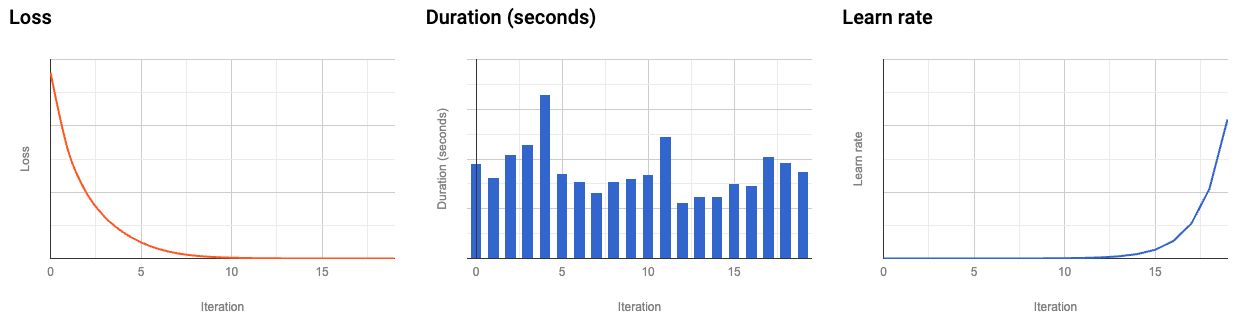

## Visualize the Prediction Model

Even though the data is high-dimensional (i.e., 30 features), we can use principal component analysis (PCA) to visualize the data in a lower dimensional space. Visualization can help with interpreting and understanding the model's performance. 

### Scale The Data

Before using PCA, the data need to be scaled to zero mean and unit variance. The original means and standard deviations of the training data are stored so that we can use them to scale the testing and future data. 

In [17]:
# Get the numeric columns of the input data, splitting into
# training and testing sets
train_data <- tmp_data[tmp_data$data_partition == 'training',]
test_data <- tmp_data[tmp_data$data_partition == 'testing',]

# Calculate the column means and stdevs of the training data in order to
# scale the data to zero mean and unit variance
train_data_numeric <- subset(
  train_data, select=-c(case_barcode, sample_type_name, label, data_partition)
)
test_data_numeric <- subset(
  test_data, select=-c(case_barcode, sample_type_name, label, data_partition)
)

# Center and scale the training data
train_means = colMeans(train_data_numeric)
train_sds = sqrt(colVars(train_data_numeric))
tm_mat <- matrix(1,nrow(train_data_numeric),1) %*% train_means
ts_mat <- matrix(1,nrow(train_data_numeric),1) %*% train_sds
train_data_numeric_norm <- (train_data_numeric - tm_mat) / ts_mat

### Calculate Principal Components

Now calculate principal components using the training data. 

In [18]:
# Calculate principal components using the training data
pca <- prcomp(train_data_numeric_norm)

### Plot Data in Principal Component Space

The samples can now be projected on to the principal components and plotted. 

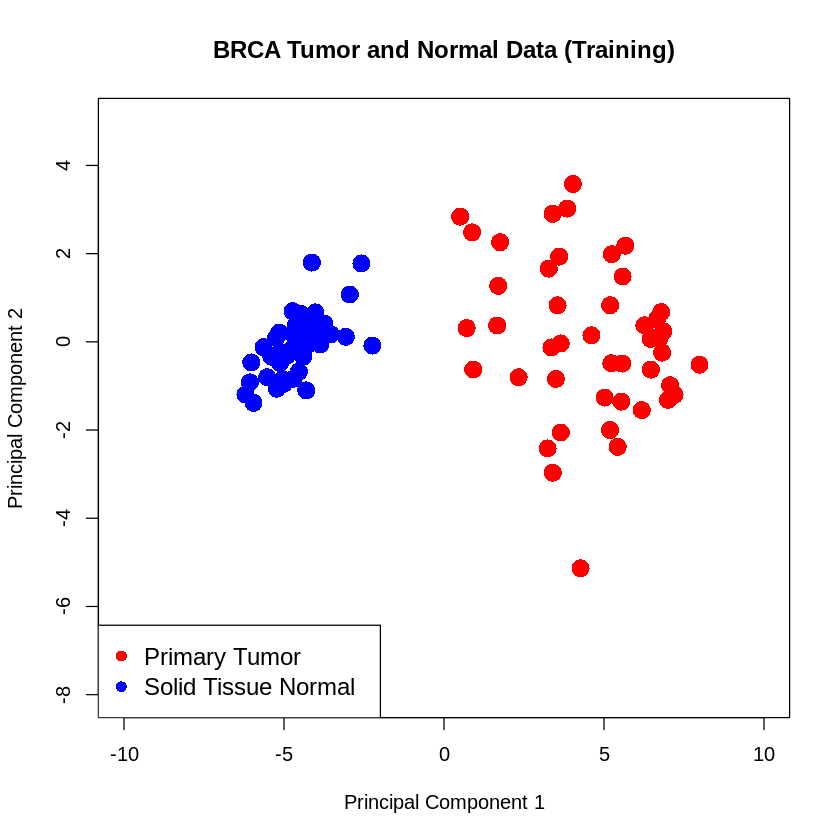

In [19]:
# Get the eigenvectors of the first two principal components
eigen_vectors <- pca$rotation[,c('PC1', 'PC2')]

# Project the training data onto the first two principal components 
train_proj <- t(eigen_vectors) %*% t(train_data_numeric_norm)

# Plot
colors <- c('red', 'blue')
plot(
  t(train_proj),
  col = colors[factor(train_data$sample_type_name)],
  pch = 16, cex = 2,
  main = 'BRCA Tumor and Normal Data (Training)',
  xlab = 'Principal Component 1',
  ylab = 'Principal Component 2',
  xlim=c(-10, 10), ylim=c(-8, 5)
)
legend(
  'bottomleft',
  legend=levels(factor(train_data$sample_type_name)),
  col = colors,
  pch = 16, cex = 1.2
)

# Evaluate the Machine Learning Model
Once the model has been trained and stored, we can evaluate the model's performance using the "testing" dataset from our subset table.

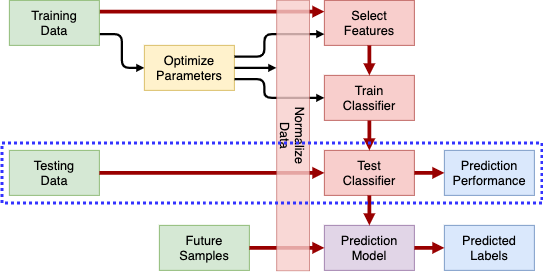

## Calculate Performance Metrics with BigQuery ML

Evaluating a BQ ML model is generally less expensive than training. In the following BQ ML query, we use the "data_partition = 'testing'" clause to ensure that we only evaluate the model with test samples from the subset table.  

BigQuery's ML.EVALUATE function returns several performance metrics: precision, recall, accuracy, f1_score, log_loss, and roc_auc. More details about these performance metrics are available from [Google's ML Crash Course](https://developers.google.com/machine-learning/crash-course/classification/video-lecture). Specific topics can be found at the following URLs: [precision and recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall), [accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy), [ROC and AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc). 

In [ ]:
# Construct query
ml_eval_query <- sprintf("
  SELECT * FROM ML.EVALUATE (MODEL `%s`, 
    (
      SELECT * EXCEPT(case_barcode, sample_type_name, data_partition)
      FROM `%s`
      WHERE data_partition = 'testing'
    )
  )
", bq_ml_model_fullname, bq_tmp_table_fullname)

# Display query
cat(ml_eval_query)

# Run the query to evaluate the model
ml_eval_result <- bq_project_query(
  google_project,
  ml_eval_query,
  quiet = TRUE
)

# Download the eval result
eval_data <- bq_table_download(ml_eval_result, quiet = TRUE)

# Display the result
eval_data

We can see from this result that prediction of tumor vs. normal breast cancer samples is very easy, with a prediction accuracy of 100% on the testing dataset. This is not surprising, since the gene expression of tumor samples is expected to be markedly different from that of normal tissue samples. Other prediction problems, such as prediction of tumor grade or therapeutic response, can be much more challenging. Prediction models for these problems would be expected to yield lower prediction accuracies. 

## Calculate Prediction Labels and Probabilities for Test Samples

We can also calculate the actual predicted labels and the probability that each sample belongs to a class using the "ML.PREDICT" BigQuery method.

In [ ]:
# Construct the query to predict each sample
ml_predict_query <- sprintf("
  SELECT
    label,
    predicted_label,
    (SELECT prob
     FROM UNNEST(predicted_label_probs)
     WHERE label = 1) AS tumor_prob,
    (SELECT prob
     FROM UNNEST(predicted_label_probs)
     WHERE label = 0) AS normal_prob

  FROM ML.PREDICT (MODEL `%s`, 
    (
      SELECT * EXCEPT(case_barcode, sample_type_name, data_partition)
      FROM `%s`
      WHERE data_partition = 'testing' -- Use the testing dataset
    )
  )
", bq_ml_model_fullname, bq_tmp_table_fullname)

# Display the query
cat(ml_predict_query)

# Run the query to evaluate the model
ml_predict_result <- bq_project_query(
  google_project,
  ml_predict_query,
  quiet = TRUE
)

# Download the eval result
ml_predict_data <- bq_table_download(ml_predict_result, quiet = TRUE)

# Display the result
head(ml_predict_data)


These results confirm that the probability of samples belonging to their predicted classes is close to 100%. 

## Visualize Prediction Results

To verify the prediction result, we can project the test samples onto the two principal components of the training data and plot the results against the training data. 

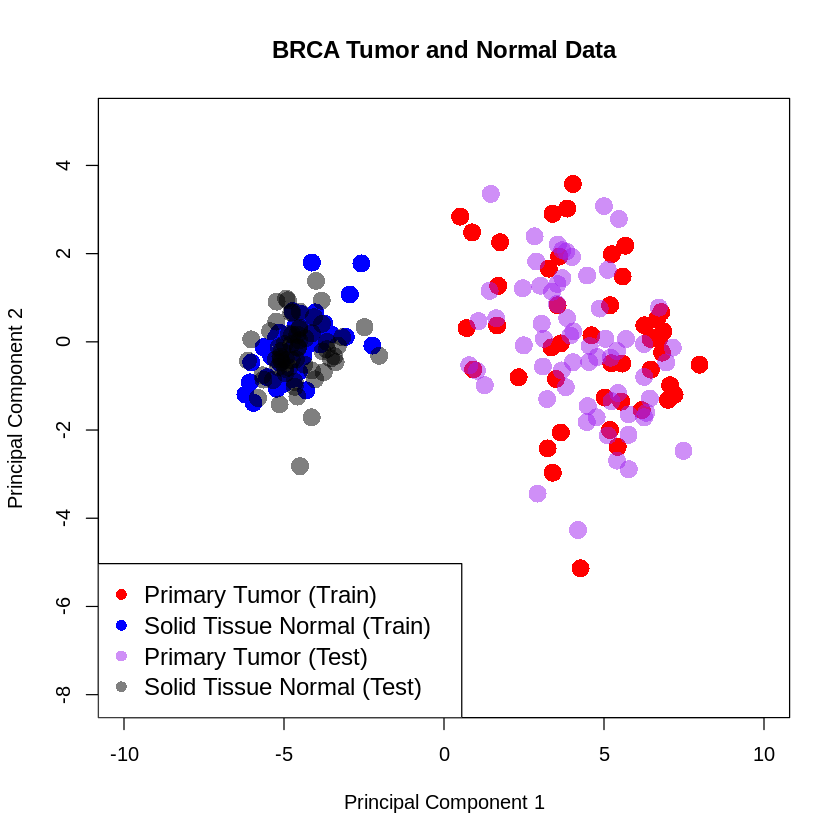

In [22]:
# Center and scale the testing data with means and stdevs of the training data
tm_mat <- matrix(1,nrow(test_data_numeric),1) %*% train_means
ts_mat <- matrix(1,nrow(test_data_numeric),1) %*% train_sds
test_data_numeric_norm <- (test_data_numeric - tm_mat) / ts_mat

# Project the test data onto the first two principal components 
test_proj <- t(eigen_vectors) %*% t(test_data_numeric_norm)

# Prepare the factors to group and label samples appropriately
train_colors <- c('red', 'blue')
test_colors <- c(alpha('purple', 0.5), alpha('black', 0.5))
train_factors <- train_data$sample_type_name
train_factors[train_factors == 'Primary Tumor'] <- 'Primary Tumor (Train)'
train_factors[train_factors == 'Solid Tissue Normal'] <- 'Solid Tissue Normal (Train)'
test_factors <- test_data$sample_type_name
test_factors[test_factors == 'Primary Tumor'] <- 'Primary Tumor (Test)'
test_factors[test_factors == 'Solid Tissue Normal'] <- 'Solid Tissue Normal (Test)'

# Use empty circles to denote mis-classified samples, and O's to denote
# correctly classified samples (in this example, all samples are correctly 
# classified)
train_pch <- c()
train_pch[1:length(train_factors)] <- 16
test_pch <- c()
test_pch[1:length(test_factors)] <- 16
test_pch[ml_predict_data$label == 1 & ml_predict_data$predicted_label == 0] <- 1
test_pch[ml_predict_data$label == 0 & ml_predict_data$predicted_label == 1] <- 1

# Plot both training and testing data on the the same axes
plot(
  t(cbind(train_proj, test_proj)),
  col = cbind(
    t(train_colors[factor(train_factors)]), t(test_colors[factor(test_factors)])
  ),
  pch = cbind(t(train_pch), t(test_pch)), cex = 2, lwd = 2,
  main = 'BRCA Tumor and Normal Data',
  xlab = 'Principal Component 1',
  ylab = 'Principal Component 2',
  xlim=c(-10, 10), ylim=c(-8, 5)
)

# Add a legend to the plot
legend(
  'bottomleft',
  legend=cbind(
    t(levels(factor(train_factors))), t(levels(factor(test_factors)))
  ),
  col = cbind(train_colors, test_colors),
  pch = cbind(t(train_pch), t(test_pch)), cex = 1.2
)

# Predict Future Samples

The BigQuery ML model can now be applied to future samples to predict whether they are normal or tumor samples. To simulate this, we use metastatic TCGA BRCA samples. These samples were previously extracted from the TCGA RNAseq BigQuery table, labeled as 'future' samples, and stored in the temporary BQ table alongside the training and testing samples. 

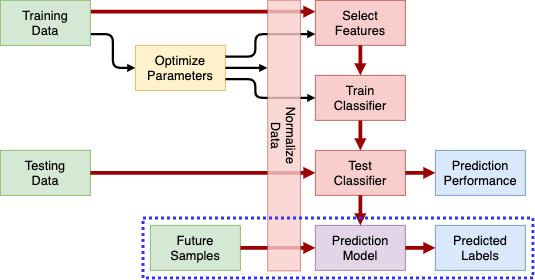

## Calculate Prediction Labels and Probabilites for Future Samples

We use 'ML.PREDICT' on these 'future' samples to predict their class labels and probabilities for each class.

In [ ]:
# Construct the query to predict each future sample
ml_future_query <- sprintf("
  SELECT
    predicted_label,
    (SELECT prob
     FROM UNNEST(predicted_label_probs)
     WHERE label = 1) AS tumor_prob,
    (SELECT prob
     FROM UNNEST(predicted_label_probs)
     WHERE label = 0) AS normal_prob

  FROM ML.PREDICT (MODEL `%s`, 
    (
      SELECT * EXCEPT(case_barcode, sample_type_name, data_partition)
      FROM `%s`
      WHERE data_partition = 'future' -- Use future dataset
    )
  )
", bq_ml_model_fullname, bq_tmp_table_fullname)

# Display the query
cat(ml_future_query)

# Run the query to evaluate the model
ml_future_result <- bq_project_query(
  google_project,
  ml_future_query,
  quiet = TRUE
)

# Download the eval result
ml_future_data <- bq_table_download(ml_future_result, quiet = TRUE)

# Display the result
ml_future_data

In the data frame of predicted labels and probabilities above, we can see that all but one of the seven samples are predicted as tumor samples.



## Scale 'Future' Metastatic Samples to Prepare for Visualization

We can visualize the 'future' metastatic samples by overlaying them on the PCA plot along with training and testing samples. To do this, we first need to normalize the samples by mean-centering and scaling them using the means and standard deviations calculated from the training data. 

In [24]:
# Get the numeric columns of the future (metastatic) data
future_data <- tmp_data[tmp_data$data_partition == 'future',]
future_data_numeric <- subset(
  future_data, select=-c(case_barcode, sample_type_name, label, data_partition)
)

# Center and scale the future data with means and stdevs of the training data
tm_mat <- matrix(1,nrow(future_data_numeric),1) %*% train_means
ts_mat <- matrix(1,nrow(future_data_numeric),1) %*% train_sds
future_data_numeric_norm <- (future_data_numeric - tm_mat) / ts_mat

# Display the normalized future data
future_data_numeric_norm

COL10A1,MMP11,ADAMTS5,CAPN11,FIGF,PAMR1,KLHL29,INHBA,PPAPDC1A,LYVE1,⋯,SLC24A2,PER1,SCARA5,COMP,SPRY2,TPX2,ROBO3,CXCL2,NDRG2,HSD17B6
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.07031358,-0.7097134,-1.5961621,-1.0488689,-0.4538187,-0.3025102,-0.6781042,-0.37577403,-0.691229017,-0.4514032,⋯,-1.0959616,-1.14153550,-0.1368610,-0.3608953,-0.8444978,0.1079138,0.5014133,-0.5265033,0.45867670,-0.8671599
0.11263779,-0.5872873,-2.0032134,-1.4568780,-1.7431609,-1.5089907,1.3474274,0.02255649,-0.862141805,-0.6289281,⋯,-1.3114651,-1.01879742,-0.1566930,0.7357694,0.2081205,1.5838067,-0.5203551,0.6176362,-1.42290695,-0.1849144
0.08794490,0.5646599,-1.2392824,-0.7133338,-0.8124305,-0.1136345,-1.3319750,-0.10685600,0.355791197,0.1034732,⋯,-0.4792869,-0.02165508,-1.2150584,0.3021092,-0.6389912,0.5519812,-1.1937827,0.6699216,-0.75255149,0.9938082
-0.39240885,-0.2199042,0.1626603,-1.4160074,-1.0498845,0.4403747,0.4232644,0.59054841,-1.042092106,1.0846413,⋯,-0.7673889,1.69677986,0.2040097,-2.2076127,1.0127801,-0.0425655,1.5440444,0.9102478,0.08184398,1.7545815
0.70912442,0.5469210,-2.3860626,-0.7495957,-1.2436025,-1.4567319,-0.8170757,0.67127335,0.009797258,-1.1787528,⋯,-0.9307181,-2.06109646,-1.1930635,1.4558260,-1.2261020,1.6705225,-0.8158202,-1.2909155,-1.59957484,0.5511753
0.38619311,0.3629761,-3.4168080,-1.1702663,-1.2315522,-1.7198494,-1.5123724,-0.17207635,-0.215091419,-1.7801310,⋯,-0.4713685,-1.11471333,-3.0691268,0.6494447,-2.0153850,0.2357412,-1.5372070,-1.7922310,-0.96683538,-0.1367400
-0.69416868,-0.5027786,-1.9201644,-1.8860144,-1.7600510,-1.7398615,-2.2328127,-0.88706043,-1.053149756,-1.4899097,⋯,-0.1314914,-1.18578449,-1.7592670,-0.1354670,-1.7066117,0.8499577,-2.0796274,-1.5785620,-0.84771896,0.4573721


## Visualize Prediction Results of 'Future' Metastatic Samples

Now we can project these samples onto the first two principal components (calculated from the training data) and plot them. 

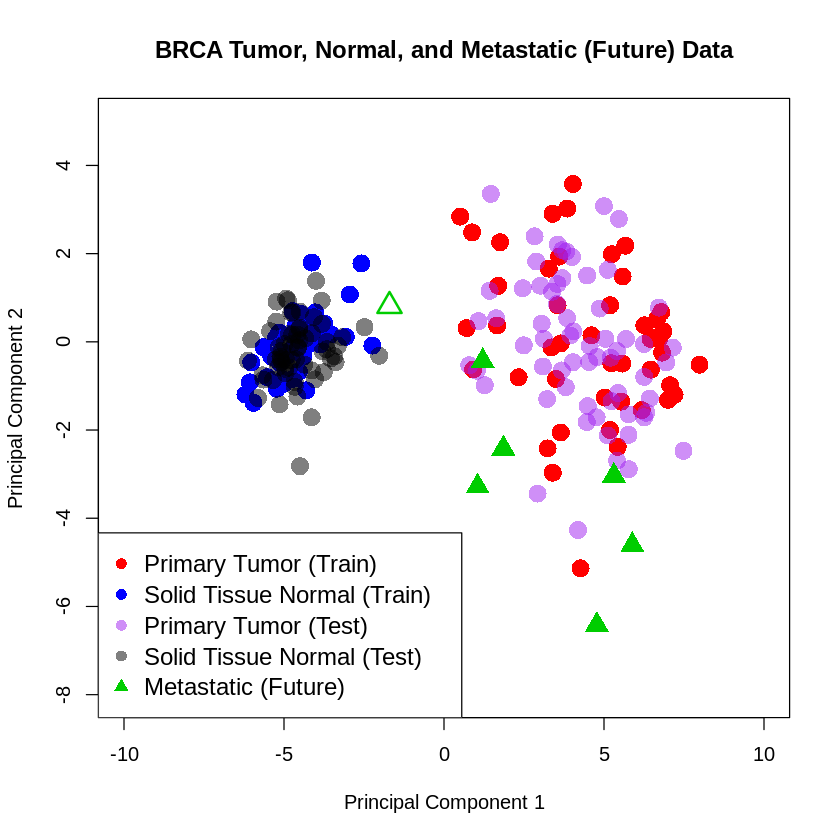

In [25]:
# Project the future data onto the first two principal components 
future_proj <- t(eigen_vectors) %*% t(future_data_numeric_norm)

# Prepare the factors to group and label samples appropriately
future_colors <- c('green3')
future_factors <- c()
future_factors[1:nrow(future_data_numeric_norm)] <- 'Metastatic (Future)'

# Use empty triangles to denote future metastatic samples classified as normal,
# and filled triangles to denote future metastatic samples classified as tumor
future_pch <- c()
future_pch[1:nrow(future_data_numeric_norm)] <- 17
future_pch[ml_future_data$predicted_label == 0] <- 2

# Plot training, testing, and future data on the the same axes
plot(
  t(cbind(train_proj, test_proj, future_proj)),
  col = cbind(
    t(train_colors[factor(train_factors)]),
    t(test_colors[factor(test_factors)]),
    t(future_colors[factor(future_factors)])
  ),
  pch = cbind(t(train_pch), t(test_pch), t(future_pch)),
  cex = 2, lwd = 2,
  main = 'BRCA Tumor, Normal, and Metastatic (Future) Data',
  xlab = 'Principal Component 1',
  ylab = 'Principal Component 2',
  xlim=c(-10, 10), ylim=c(-8, 5)
)

# Add a legend to the plot
legend(
  'bottomleft',
  legend=cbind(
    t(levels(factor(train_factors))),
    t(levels(factor(test_factors))),
    t(levels(factor(future_factors)))
  ),
  col = cbind(train_colors, test_colors, future_colors),
  pch = cbind(16, 16, 16, 16, 17), cex = 1.2
)

# Interpretation and Conclusion

This tutorial introduced BigQuery ML concepts by demonstrating an end-to-end workflow for predicting the tumor status (tumor vs. normal) of TCGA breast cancer RNA-seq samples. We created a BigQuery ML model using training samples, evaluated the model using testing samples, then used the final model to predict the tumor status of 'future' samples. 

The PCA plot of 'future' metastatic samples verifies what we observed in the predicted labels and probabilities. In principal component space, all but one metastatic sample group with the tumor samples (red and purple circles). A single sample (empty green triangle) is closer to the normal samples (blue and gray circles), which explains why the ML model classifies it as normal. The following are comments/caveats for this analysis:

1. The use of metastatic samples as 'future' data is purely for the purposes of simulation and demonstration of how this prediction model can be applied to future samples. This prediction model was trained with no information about metastatic samples. Thus, the resulting prediction labels may not be biologically sensible. 

2. A more appropriate analysis approach could be to split the normal and tumor data into 'training', 'testing', and 'validation' samples, then using the 'validation' set in place of the 'future' samples. 

3. Used for data exploration, these results may be interpreted in the following ways:

  a. The single metastatic sample has a gene expression signature that is similar to that of normal tissue and may warrant further biological investigation. 
  
  b. The single metastatic sample has been mis-classified or mis-diagnosed and should be further investigated. 

# Follow-Up Exercises

Practice your BigQuery ML skills by solving the following exercises on your own. Come to our office hours to see the solutions. 

1. We've seen that this machine learning model can be used to predict whether TCGA-BRCA RNA-seq samples are tumor or normal samples. What happens if we apply the model to a different cancer (e.g., TCGA-GBM)? What are the implications of training a model with one cancer type and applying it to other cancer types?

2. Feature selection can have a big effect on downstream prediction performance. Demonstrate this effect by training the model using genes that are **not** differentially expressed. For example, you can use DESeq to select the bottom 30 differentially expressed genes, or you can randomly select a set of genes. 

# Contact Us

Please contact us to learn more about BigQuery, to discuss cost considerations when working with BigQuery projects, or to discuss any projects you feel may benefit from the ISB-CGC Platform. 

- Email us: [feedback@isb-cgc.org](mailto:feedback@isb-cgc.org)
- Check out our website: [https://isb-cgc.org](https://isb-cgc.org)
- Visit our [office hours](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/office_hours.html)